In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [4]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.attack.naturalness import AdvContentLoss
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates, process_depth, disp_to_depth, median_scaling
from adv_manhole.texture_mapping.depth_mapping import DepthTextureMapping


## Load Dataset

In [5]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

In [ ]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config", "semantic"]
)

data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
            "road_mask": transforms.ToTensor()(
                np.any(np.array(example['semantic']) == np.array((128, 64, 128)), axis=-1).astype(np.float32)
            ),
            "depth": transforms.ToTensor()(
                process_depth(example["raw_depth"]) * 1000.0 # Convert to meters
            )
        },
        remove_columns=["raw_depth", "camera_config", "semantic"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


In [7]:
original_index = 0 # Road
# target_indices = list(range(1, 13))  # All classes except Road
target_indices = [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18]  # Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle

## Load Adversarial Manholes

In [8]:
imsize = 256  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to("cuda", torch.float)

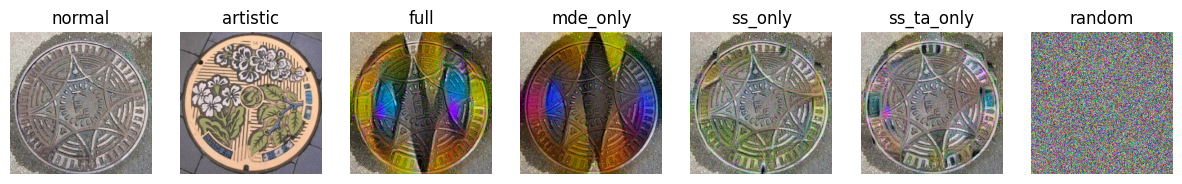

In [87]:
adversarial_manhole_paths = {
    "normal": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/manhole/P1OPDAMV5BDF.jpg',
    "artistic": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/artistic_manhole.jpg',
    "full": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle/texture_epoch_24.png',
    "mde_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_mde_only/texture_epoch_24.png',
    "ss_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_ss_only/texture_epoch_24.png',
    "ss_ta_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_targeted_only/texture_epoch_24.png'
}

# Load the manholes
manhole_images = {}
for key, path in adversarial_manhole_paths.items():
    manhole_images[key] = image_loader(path)

manhole_images['random'] = torch.rand_like(manhole_images['normal'])

# Plot the manholes
plt.figure(figsize=(15, 5))
for i, (key, image) in enumerate(manhole_images.items()):
    plt.subplot(1, 7, i+1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(key)
    plt.axis('off')
plt.show()

## Load Model

In [10]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-06-04 02:10:29] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

In [11]:
# def error_distance(predicted_disp, original_disp, texture_masks):
#     """
#     Calculates the error distance between predicted and original depth maps.

#     Args:
#         predicted_disp (torch.Tensor): Predicted disparity map.
#         original_disp (torch.Tensor): Original disparity map.
#         texture_masks (torch.Tensor): Texture masks.

#     Returns:
#         torch.Tensor: Mean error distance between predicted and original depth maps.
#     """
#     predicted_depth = 1 / (predicted_disp + 1e-6)
#     original_depth = 1 / (original_disp + 1e-6)

#     error = torch.abs(predicted_depth - original_depth)
#     error_masked = error[texture_masks > 0.5]
#     return error_masked.mean()

# def asr_semantic_segmentation(predicted_semantic, original_index, target_indices, texture_masks):
#     """
#     Calculate the Attack Success Rate (ASR) for semantic segmentation for both untargeted and targeted attacks.

#     Args:
#         predicted_semantic: torch.Tensor, shape (N, C, H, W), the predicted semantic segmentation.
#         original_index: int, the original class index.
#         target_indices: list of int, the target class indices.
#         texture_masks: torch.Tensor, shape (N, 1, H, W), the texture masks.

#     Returns:
#         Tuple of floats, the untargeted ASR and targeted ASR.
#     """

#     # Get the predicted class indices
#     predicted_indices = predicted_semantic.argmax(dim=1)

#     # Get the texture masks
#     texture_masks = texture_masks.squeeze()

#     # Calculate the untargeted ASR
#     untargeted_asr = (predicted_indices != original_index).float()
#     untargeted_asr = untargeted_asr[texture_masks > 0.5].mean()

#     # Calculate the targeted ASR
#     targeted_asr = torch.zeros(predicted_indices.shape, device=predicted_indices.device)
#     for target_index in target_indices:
#         targeted_asr += (predicted_indices == target_index).float()
#     targeted_asr = targeted_asr[texture_masks > 0.5].mean()

#     return untargeted_asr, targeted_asr

In [70]:
def error_distance_region(predicted_depth, original_depth, texture_masks, road_masks, distance_threshold=0.25, output_region=False):
    """
    Calculate the relative error distance mean and ratio for depth maps in road area.

    Args:
        predicted_depth (torch.Tensor, shape (N, 1, H, W)): Predicted depth map.
        original_depth (torch.Tensor, shape (N, 1, H, W)): Original depth map.
        texture_masks (torch.Tensor, shape (N, 1, H, W)): Binary mask indicating texture regions.
        road_masks (torch.Tensor, shape (N, 1, H, W)): Binary mask indicating road regions.
        distance_threshold (float, optional): Threshold for error distance. Defaults to 0.1.
        output_region (bool, optional): Whether to output the error distance region. Defaults to False.

    Returns:
        Dict of floats, the relative error distance mean and ratio.
    """


    # Calculate abs rel error distance
    # predicted_depth = 1 / (predicted_disp + 1e-6)
    # original_depth = 1 / (original_disp + 1e-6)
    error = torch.abs(original_depth - predicted_depth) / original_depth

    # Error distance masked
    error_masked = error[texture_masks > 0.5]

    # Calculate error distance region
    error_distance_region = (error > distance_threshold).float() * road_masks

    # Calculate the error area for each sample
    error_area = error_distance_region.squeeze(1).sum(dim=(1, 2))

    # Make sure the error area shape is same as batch size
    # assert error_area.shape == road_masks.shape[0], f"Error area shape {error_area.shape} != {road_masks.shape[0]}"

    # Calculate the texture area for each sample
    texture_area = texture_masks.squeeze(1).sum(dim=(1, 2))

    # Make sure the texture area shape is same as batch size
    # assert texture_area.shape == road_masks.shape[0], f"Texture area shape {texture_area.shape} != {road_masks.shape[0]}"

    # Calculate the ratio of error distance region to texture area
    ratio = error_area / texture_area

    if output_region:
        return {
            "ed_mean": error_masked.mean(),
            "ed_ratio": ratio.mean(),
            "ed_region": error_distance_region
        }

    return {
        "ed_mean": error_masked.mean(),
        "ed_ratio": ratio.mean()
    }


def asr_segmentation_region(predicted_semantic, original_semantic, original_index, target_indices, texture_masks, road_masks, output_region=False):
    """
    Calculate the Attack Success Rate (ASR) for semantic segmentation for both untargeted and targeted attacks in road area.

    Args:
        predicted_semantic: torch.Tensor, shape (N, C, H, W), the predicted semantic segmentation.
        original_semantic: torch.Tensor, shape (N, C, H, W), the original semantic segmentation.
        original_index: int, the original class index.
        target_indices: list of int, the target class indices.
        texture_masks: torch.Tensor, shape (N, 1, H, W), the texture masks.
        road_masks: torch.Tensor, shape (N, 1, H, W), the road masks.
        output_region: bool, optional, whether to output the region. Defaults to False.

    Returns:
        Dict of floats, the untargeted ASR and targeted ASR in road area.
    """

    # Get the predicted class indices
    predicted_indices = predicted_semantic.argmax(dim=1)
    
    # Get original class indicies
    original_indicies = original_semantic.argmax(dim=1)

    # Get the texture masks
    texture_masks = texture_masks.squeeze(1)

    # Get the road masks
    road_masks = road_masks.squeeze(1)

    # Get original road masks
    original_road_masks = (original_indicies == original_index).float()

    # Calculate the untargeted ASR in texture area
    untargeted_asr = (predicted_indices != original_index).float()
    untargeted_asr_mean = untargeted_asr[texture_masks > 0.5].mean()
    
    # Calculate the targeted ASR in texture area
    targeted_asr = torch.zeros(predicted_indices.shape, device=predicted_indices.device)
    for target_index in target_indices:
        targeted_asr += (predicted_indices == target_index).float()
    targeted_asr_mean = targeted_asr[texture_masks > 0.5].mean()

    # Calculate the texture area
    texture_area = texture_masks.squeeze(1).sum(dim=(1, 2))

    # Calculate the rea from untargeted ASR in road area
    untargeted_asr_road = (untargeted_asr * road_masks * original_road_masks)
    untargeted_area = untargeted_asr_road.squeeze(1).sum(dim=(1, 2))

    # Calculate the ratio of area from targeted ASR in road area
    targeted_area_road = (targeted_asr * road_masks * original_road_masks)
    targeted_area = targeted_area_road.squeeze(1).sum(dim=(1, 2))

    # Calculate the ratio of area from untargeted ASR in road area to texture area
    untargeted_ratio = (untargeted_area / texture_area)

    # Calculate the ratio of area from targeted ASR in road area to texture area
    targeted_ratio = targeted_area / texture_area

    if output_region:
        return {
            "asr_ua_mean": untargeted_asr_mean,
            "asr_ta_mean": targeted_asr_mean,
            "ua_ratio": untargeted_ratio.mean(),
            "ta_ratio": targeted_ratio.mean(),
            "ua_region": untargeted_asr_road,
            "ta_region": targeted_area_road
        }

    return {
        "asr_ua_mean": untargeted_asr_mean,
        "asr_ta_mean": targeted_asr_mean,
        "ua_ratio": untargeted_ratio.mean(),
        "ta_ratio": targeted_ratio.mean()
    }

In [29]:
depth_planar_mapping = DepthTextureMapping(
    random_scale=(0.0, 0.01),
    with_circle_mask=True,
    device="cuda",
)

In [30]:
def forward(
        batch, 
        patch_texture = None,
        tex_scales = None,
        xyz_offsets = None,
        device = None,
    ):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    rgb = batch["rgb"].to(device)
    local_surface_coors = batch["local_surface_coors"].to(device)

    current_batch_size = rgb.shape[0]

    if patch_texture is not None:
        # Repeat the texture to match the batch size
        batched_texture = patch_texture.repeat(
            current_batch_size, 1, 1, 1
        )

        final_images, texture_masks = depth_planar_mapping(
            batched_texture, local_surface_coors, rgb, current_batch_size, tex_scales=tex_scales, xyz_offsets=xyz_offsets, random_scale=False, random_shift=False
        )

        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(final_images)
        predicted_semantic = ddrnet_model(final_images)

        return predicted_disp, predicted_semantic, texture_masks

    else:
        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(rgb)
        predicted_semantic = ddrnet_model(rgb)

        return predicted_disp, predicted_semantic, None

In [31]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [32]:
batch = next(iter(data_iterable["train"]))
with torch.no_grad():
    ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)

    normal_predicted_disp, normal_predicted_semantic, texture_masks = forward(batch, manhole_images["normal"])

    full_predicted_disp, full_predicted_semantic, _ = forward(batch, manhole_images["full"])

In [ ]:
ori_predicted_depth = disp_to_depth(ori_predicted_disp)
scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, batch["depth"].to('cuda'))

print(scaled_predicted_depth.shape, ratio)

torch.Size([8, 1, 720, 1280]) tensor(0.1117, device='cuda:0', dtype=torch.float64)


In [34]:
attacked_predicted_depth = disp_to_depth(full_predicted_disp)
attacked_scaled_predicted_depth = attacked_predicted_depth * ratio

In [39]:
normal_predicted_depth = disp_to_depth(normal_predicted_disp) * ratio

In [83]:
train_eval_metrics = defaultdict(list)

with tqdm(
    data_iterable['train'], total=train_total_batch, desc=f"Train Evaluation"
) as train_pbar:
    for batch in train_pbar:
        metrics = {}

        road_masks = batch["road_mask"].cuda()
        gt_depth = batch["depth"].to('cuda')

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)
            ori_predicted_depth = disp_to_depth(ori_predicted_disp)
            ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

            for manhole_name, manhole_image in manhole_images.items():
                # print(key)
                predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

                scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

                # Calculate the error distance
                mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

                for mde_key in mde_metrics.keys():
                    train_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

                # Calculate the ASR
                ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
                for ss_key in ss_metrics.keys():
                    train_eval_metrics[f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(train_eval_metrics[key])
                for key in train_eval_metrics.keys()
            })

        train_pbar.set_postfix(metrics)


Train Evaluation: 100%|█████████▉| 199/200 [12:00<00:03,  3.59s/it, normal/ed_mean=0.025, normal/ed_ratio=0.0171, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00227, normal/ta_ratio=2.56e-5, artistic/ed_mean=0.0464, artistic/ed_ratio=0.0263, artistic/asr_ua_mean=0.000328, artistic/asr_ta_mean=4.18e-5, artistic/ua_ratio=0.00456, artistic/ta_ratio=0.000143, full/ed_mean=0.487, full/ed_ratio=2.01, full/asr_ua_mean=0.987, full/asr_ta_mean=0.987, full/ua_ratio=1.04, full/ta_ratio=1, mde_only/ed_mean=0.489, mde_only/ed_ratio=1.9, mde_only/asr_ua_mean=0.000287, mde_only/asr_ta_mean=2.26e-8, mde_only/ua_ratio=0.00718, mde_only/ta_ratio=7.94e-5, ss_only/ed_mean=0.0581, ss_only/ed_ratio=0.0303, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.97, ss_only/ua_ratio=1.14, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0716, ss_ta_only/ed_ratio=0.0489, ss_ta_only/asr_ua_mean=0.99, ss_ta_only/asr_ta_mean=0.989, ss_ta_only/ua_ratio=1.05, ss_ta_only/ta_ratio=1]   

In [84]:
val_eval_metrics = defaultdict(list)

with tqdm(
    data_iterable['validation'], total=train_total_batch, desc=f"Validation Evaluation"
) as val_pbar:
    for batch in val_pbar:
        metrics = {}

        road_masks = batch["road_mask"].cuda()
        gt_depth = batch["depth"].to('cuda')

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)
            ori_predicted_depth = disp_to_depth(ori_predicted_disp)
            ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

            for manhole_name, manhole_image in manhole_images.items():
                # print(key)
                predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

                scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

                # Calculate the error distance
                mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

                for mde_key in mde_metrics.keys():
                    val_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

                # Calculate the ASR
                ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
                for ss_key in ss_metrics.keys():
                    val_eval_metrics[f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(val_eval_metrics[key])
                for key in val_eval_metrics.keys()
            })

        val_pbar.set_postfix(metrics)

Validation Evaluation:  33%|███▎      | 66/200 [03:58<08:02,  3.60s/it, normal/ed_mean=0.0249, normal/ed_ratio=0.0213, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00237, normal/ta_ratio=1.19e-5, artistic/ed_mean=0.0454, artistic/ed_ratio=0.03, artistic/asr_ua_mean=0.000773, artistic/asr_ta_mean=4.93e-5, artistic/ua_ratio=0.00559, artistic/ta_ratio=7.85e-5, full/ed_mean=0.486, full/ed_ratio=1.98, full/asr_ua_mean=0.985, full/asr_ta_mean=0.985, full/ua_ratio=1.05, full/ta_ratio=1.01, mde_only/ed_mean=0.488, mde_only/ed_ratio=1.88, mde_only/asr_ua_mean=0.000561, mde_only/asr_ta_mean=2.26e-5, mde_only/ua_ratio=0.00941, mde_only/ta_ratio=4.67e-5, ss_only/ed_mean=0.0577, ss_only/ed_ratio=0.0318, ss_only/asr_ua_mean=0.971, ss_only/asr_ta_mean=0.967, ss_only/ua_ratio=1.14, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0729, ss_ta_only/ed_ratio=0.0585, ss_ta_only/asr_ua_mean=0.989, ss_ta_only/asr_ta_mean=0.989, ss_ta_only/ua_ratio=1.06, ss_ta_only/ta_ratio=1.01]  

In [85]:
test_eval_metrics = defaultdict(list)

with tqdm(
    data_iterable['test'], total=train_total_batch, desc=f"Test Evaluation"
) as test_pbar:
    for batch in test_pbar:
        metrics = {}

        road_masks = batch["road_mask"].cuda()
        gt_depth = batch["depth"].to('cuda')

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)
            ori_predicted_depth = disp_to_depth(ori_predicted_disp)
            ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

            for manhole_name, manhole_image in manhole_images.items():
                # print(key)
                predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

                scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

                # Calculate the error distance
                mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

                for mde_key in mde_metrics.keys():
                    test_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

                # Calculate the ASR
                ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
                for ss_key in ss_metrics.keys():
                    test_eval_metrics[f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(test_eval_metrics[key])
                for key in test_eval_metrics.keys()
            })

        test_pbar.set_postfix(metrics)

Test Evaluation:  33%|███▎      | 66/200 [03:58<08:04,  3.62s/it, normal/ed_mean=0.0271, normal/ed_ratio=0.0225, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.000979, normal/ta_ratio=3e-5, artistic/ed_mean=0.0475, artistic/ed_ratio=0.0391, artistic/asr_ua_mean=4.06e-5, artistic/asr_ta_mean=2.26e-5, artistic/ua_ratio=0.00208, artistic/ta_ratio=9.02e-5, full/ed_mean=0.484, full/ed_ratio=2.01, full/asr_ua_mean=0.985, full/asr_ta_mean=0.985, full/ua_ratio=1.03, full/ta_ratio=1, mde_only/ed_mean=0.486, mde_only/ed_ratio=1.91, mde_only/asr_ua_mean=0, mde_only/asr_ta_mean=0, mde_only/ua_ratio=0.00326, mde_only/ta_ratio=5.42e-5, ss_only/ed_mean=0.058, ss_only/ed_ratio=0.0371, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.971, ss_only/ua_ratio=1.13, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0714, ss_ta_only/ed_ratio=0.066, ss_ta_only/asr_ua_mean=0.987, ss_ta_only/asr_ta_mean=0.987, ss_ta_only/ua_ratio=1.04, ss_ta_only/ta_ratio=0.998]         

Test Evaluation:  34%|███▎      | 67/200 [04:00<07:58,  3.60s/it, normal/ed_mean=0.0269, normal/ed_ratio=0.0222, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00097, normal/ta_ratio=2.96e-5, artistic/ed_mean=0.0483, artistic/ed_ratio=0.042, artistic/asr_ua_mean=4e-5, artistic/asr_ta_mean=2.22e-5, artistic/ua_ratio=0.00206, artistic/ta_ratio=8.89e-5, full/ed_mean=0.485, full/ed_ratio=2.01, full/asr_ua_mean=0.985, full/asr_ta_mean=0.985, full/ua_ratio=1.03, full/ta_ratio=1, mde_only/ed_mean=0.487, mde_only/ed_ratio=1.92, mde_only/asr_ua_mean=0, mde_only/asr_ta_mean=0, mde_only/ua_ratio=0.00323, mde_only/ta_ratio=5.34e-5, ss_only/ed_mean=0.0584, ss_only/ed_ratio=0.0367, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.971, ss_only/ua_ratio=1.13, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0719, ss_ta_only/ed_ratio=0.067, ss_ta_only/asr_ua_mean=0.987, ss_ta_only/asr_ta_mean=0.987, ss_ta_only/ua_ratio=1.04, ss_ta_only/ta_ratio=0.998] 


In [90]:
with tqdm(
    data_iterable['train'], total=train_total_batch, desc=f"Train Evaluation"
) as train_pbar:
    for batch in train_pbar:
        metrics = {}

        road_masks = batch["road_mask"].cuda()
        gt_depth = batch["depth"].to('cuda')

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)
            ori_predicted_depth = disp_to_depth(ori_predicted_disp)
            ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

            manhole_name, manhole_image = "random", manhole_images['random']
            # print(key)
            predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

            scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

            # Calculate the error distance
            mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

            for mde_key in mde_metrics.keys():
                train_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

            # Calculate the ASR
            ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
            for ss_key in ss_metrics.keys():
                train_eval_metrics[f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(train_eval_metrics[key])
                for key in train_eval_metrics.keys()
            })

        train_pbar.set_postfix(metrics)

Train Evaluation: 100%|█████████▉| 199/200 [07:41<00:02,  2.34s/it, normal/ed_mean=0.0249, normal/ed_ratio=0.017, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00226, normal/ta_ratio=2.55e-5, artistic/ed_mean=0.0462, artistic/ed_ratio=0.0262, artistic/asr_ua_mean=0.000327, artistic/asr_ta_mean=4.16e-5, artistic/ua_ratio=0.00454, artistic/ta_ratio=0.000142, full/ed_mean=0.487, full/ed_ratio=2.01, full/asr_ua_mean=0.987, full/asr_ta_mean=0.987, full/ua_ratio=1.04, full/ta_ratio=1, mde_only/ed_mean=0.489, mde_only/ed_ratio=1.9, mde_only/asr_ua_mean=0.000286, mde_only/asr_ta_mean=2.24e-8, mde_only/ua_ratio=0.00716, mde_only/ta_ratio=7.9e-5, ss_only/ed_mean=0.0581, ss_only/ed_ratio=0.0301, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.97, ss_only/ua_ratio=1.14, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0717, ss_ta_only/ed_ratio=0.0486, ss_ta_only/asr_ua_mean=0.989, ss_ta_only/asr_ta_mean=0.989, ss_ta_only/ua_ratio=1.05, ss_ta_only/ta_ratio=1, random/ed_mean=0.0295, rand

In [91]:
with tqdm(
    data_iterable['test'], total=test_total_batch, desc=f"Test Evaluation"
) as test_pbar:
    for batch in test_pbar:
        metrics = {}

        road_masks = batch["road_mask"].cuda()
        gt_depth = batch["depth"].to('cuda')

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)
            ori_predicted_depth = disp_to_depth(ori_predicted_disp)
            ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

            manhole_name, manhole_image = "random", manhole_images['random']
            # print(key)
            predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

            scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

            # Calculate the error distance
            mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

            for mde_key in mde_metrics.keys():
                train_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

            # Calculate the ASR
            ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
            for ss_key in ss_metrics.keys():
                train_eval_metrics[f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(train_eval_metrics[key])
                for key in train_eval_metrics.keys()
            })

        test_pbar.set_postfix(metrics)

Test Evaluation:  99%|█████████▊| 66/67 [02:32<00:02,  2.31s/it, normal/ed_mean=0.0249, normal/ed_ratio=0.017, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00226, normal/ta_ratio=2.55e-5, artistic/ed_mean=0.0462, artistic/ed_ratio=0.0262, artistic/asr_ua_mean=0.000327, artistic/asr_ta_mean=4.16e-5, artistic/ua_ratio=0.00454, artistic/ta_ratio=0.000142, full/ed_mean=0.487, full/ed_ratio=2.01, full/asr_ua_mean=0.987, full/asr_ta_mean=0.987, full/ua_ratio=1.04, full/ta_ratio=1, mde_only/ed_mean=0.489, mde_only/ed_ratio=1.9, mde_only/asr_ua_mean=0.000286, mde_only/asr_ta_mean=2.24e-8, mde_only/ua_ratio=0.00716, mde_only/ta_ratio=7.9e-5, ss_only/ed_mean=0.0581, ss_only/ed_ratio=0.0301, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.97, ss_only/ua_ratio=1.14, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0717, ss_ta_only/ed_ratio=0.0486, ss_ta_only/asr_ua_mean=0.989, ss_ta_only/asr_ta_mean=0.989, ss_ta_only/ua_ratio=1.05, ss_ta_only/ta_ratio=1, random/ed_mean=0.0298, random/

Test Evaluation: 100%|██████████| 67/67 [02:33<00:00,  2.30s/it, normal/ed_mean=0.0249, normal/ed_ratio=0.017, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00226, normal/ta_ratio=2.55e-5, artistic/ed_mean=0.0462, artistic/ed_ratio=0.0262, artistic/asr_ua_mean=0.000327, artistic/asr_ta_mean=4.16e-5, artistic/ua_ratio=0.00454, artistic/ta_ratio=0.000142, full/ed_mean=0.487, full/ed_ratio=2.01, full/asr_ua_mean=0.987, full/asr_ta_mean=0.987, full/ua_ratio=1.04, full/ta_ratio=1, mde_only/ed_mean=0.489, mde_only/ed_ratio=1.9, mde_only/asr_ua_mean=0.000286, mde_only/asr_ta_mean=2.24e-8, mde_only/ua_ratio=0.00716, mde_only/ta_ratio=7.9e-5, ss_only/ed_mean=0.0581, ss_only/ed_ratio=0.0301, ss_only/asr_ua_mean=0.974, ss_only/asr_ta_mean=0.97, ss_only/ua_ratio=1.14, ss_only/ta_ratio=1.01, ss_ta_only/ed_mean=0.0717, ss_ta_only/ed_ratio=0.0486, ss_ta_only/asr_ua_mean=0.989, ss_ta_only/asr_ta_mean=0.989, ss_ta_only/ua_ratio=1.05, ss_ta_only/ta_ratio=1, random/ed_mean=0.0298, random/

In [88]:
import pandas as pd

train_eval_metrics_df = pd.DataFrame(train_eval_metrics)
val_eval_metrics_df =  pd.DataFrame(val_eval_metrics)
test_eval_metrics_df = pd.DataFrame(test_eval_metrics)

# SAVE TO CSV
train_eval_metrics_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/train_eval_metrics.csv")
val_eval_metrics_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/val_eval_metrics.csv")
test_eval_metrics_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/test_eval_metrics.csv")


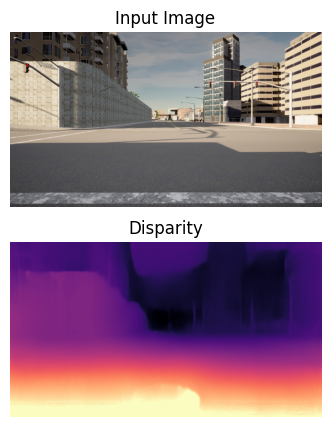

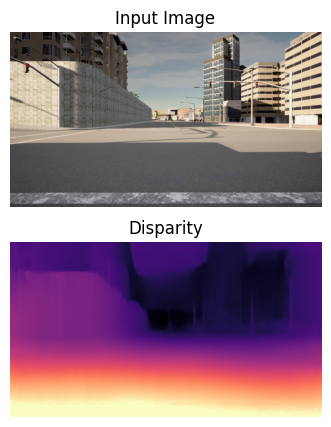

In [18]:
# Plot the depth map
fig = monodepth2_model.plot(batch['rgb'][0].detach().cpu().permute(1, 2, 0), predicted_disp[0])
plt.show()

fig = monodepth2_model.plot(batch['rgb'][0].detach().cpu().permute(1, 2, 0), ori_predicted_disp[0])
plt.show()

In [ ]:
error = torch.abs(predicted_disp - ori_predicted_disp)
print(error.shape)

torch.Size([8, 1, 720, 1280])


In [21]:
# Plot the error map and colorbar for each image
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(error[i].detach().cpu().squeeze(), cmap='hot')
    plt.colorbar()
    plt.title(f"Error {i}")
    plt.axis('off')

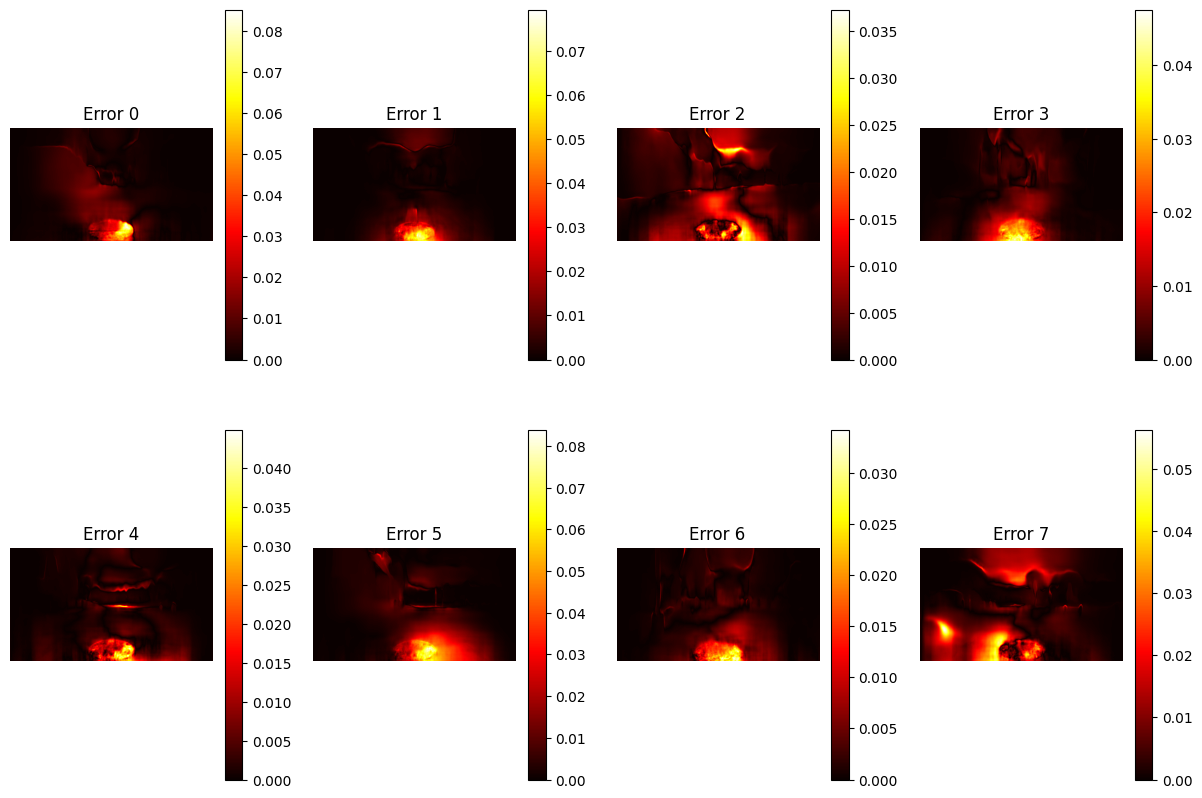

In [22]:
plt.show()